In [103]:
import numpy as np
import sympy as sp
from dataclasses import dataclass
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
d = np.array([0.1807, 0, 0, 0.17415, 0.11985, 0.11655])
r = np.array([0, -0.6127, -0.57155, 0, 0, 0])
alpha = np.array([np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0])

In [129]:
@dataclass
class UR10:
    _d = np.array([0.1807, 0, 0, 0.17415, 0.11985, 0.11655])
    _r = np.array([0, -0.6127, -0.57155, 0, 0, 0])
    _alpha = np.array([np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0])
    
    def _T(self, theta, i):
        return np.array([
            [np.cos(theta), -np.sin(theta)*np.cos(self._alpha[i]), np.sin(theta)*np.sin(self._alpha[i]), self._r[i]*np.cos(theta)],
            [np.sin(theta), np.cos(theta)*np.cos(self._alpha[i]), -np.cos(theta)*np.sin(self._alpha[i]), self._r[i]*np.sin(theta)],
            [0, np.sin(self._alpha[i]), np.cos(self._alpha[i]), self._d[i]],
            [0, 0, 0, 1]])
    
    def Tij(self, i: int, j: int, theta)->np.ndarray:
        """Transform from frame i to frame j

        Args:
            theta (np.ndarray): list of angles starting from frame i+1 up to frame j
            i (int): frame to transform from
            j (int): frame to transform to

        Returns:
            np.ndarray: Homogenous transformation matrix
        """
        assert(i<j)

        T_ij = np.eye(4)
        k = 0
        for i in range(i, j):
            T_ij = T_ij@self._T(theta[k], i)
            k += 1
        return T_ij

    def T(self, x_ax: np.ndarray, y_ax, z_ax, pos):
        dh_mat = np.concatenate([np.hstack([x_ax.reshape((-1, 1)), y_ax.reshape((-1, 1)), z_ax.reshape((-1, 1)), pos.reshape((-1, 1))]), np.array([0, 0, 0, 1]).reshape((1, -1))], 0)
        return dh_mat

    def W(self, omega):
        return np.array([
            [0, -omega[2], omega[1], v[0]],
            [omega[2], 0, -omega[0], v[1]],
            [-omega[1], omega[0], 0, v[2]],
            [0, 0, 0]])
    
    @staticmethod
    def InvertDHMat(mat: np.ndarray) -> np.ndarray:
        R = mat[0:3, 0:3]
        mat[0:3, 0:3] = R.T
        mat[0:3, 3] = -R.T @ mat[0:3, 3] 
        return mat

    
    # def URAnalyticIK(self, e_pose: np.ndarray):
    #     z6_0 = e_pose[0:3, 2]  # z axis of the 6th frame from DH-matrix 
    #     y6_0 = e_pose[0:3, 1]
    #     x6_0 = e_pose[0:3, 0]
        
    #     p6_0 = e_pose[0:3, 3]
    #     p05_0 = p6_0 - self._d[5]*z6_0
    #     R = np.linalg.norm(p05_0[:2])
        
    #     theta = np.ones((6, 8))

    #     theta1 = np.array([
    #         np.arctan2(p05_0[1], p05_0[0]) + np.arccos(self._d[3]/R) + np.pi/2,
    #         np.arctan2(p05_0[1], p05_0[0]) - np.arccos(self._d[3]/R) + np.pi/2])
        
    #     theta[0, :4] = np.repeat(theta1[0], 4, 0)
    #     theta[0, 4:] = np.repeat(theta1[1], 4, 0)


    #     theta[4, :] = np.arccos(
    #         np.clip(
    #         (p6_0[0]*np.sin(theta[0]) - p6_0[1]*np.cos(theta[0]) - self._d[3]) / self._d[5], 
    #         -1, 1))
    #     theta[4, 0:2] *= -1
    #     theta[4, 4:6] *= -1
        

    #     theta[5, :] = np.array([np.arctan2(
    #         (-y6_0[0]*np.sin(theta[0]) + y6_0[1]*np.cos(theta[0])) / np.sin(theta[4]),
    #         -(-x6_0[0]*np.sin(theta[0]) + x6_0[1]*np.cos(theta[0])) / np.sin(theta[4])
    #     )])
    #     np.nan_to_num(theta[5], copy=False)
        
    #     # to find theta2, theta3, theta4 we solve planar 3R problem. We let the 

    #     for i in range(0,8,2):
    #         T10 = np.linalg.inv(self.Tij(0, 1, [theta[0, i]]))
    #         T54 = np.linalg.inv(self.Tij(4, 5, [theta[4, i]]))
    #         T65 = np.linalg.inv(self.Tij(5, 6, [theta[5, i]]))
    #         T15 = T10@e_pose@T65  
    #         T14 = T15@T54
    #         x1_1 = np.array([1, 0, 0])
    #         x5_1 = T15[:3, 0]
    #         gamma = np.arccos(x5_1@x1_1)
    #         L12, L23, L34 = self._r[1], self._r[2], self._d[4]
    #         x4 = T14[0, -1]
    #         y4 = T14[1, -1]
    #         xe = T15[0, -1] -L34*np.cos(gamma)
    #         ye = T15[1, -1] -L34*np.sin(gamma)
            
    #         alpha = np.arccos((x4**2 + y4**2 - self._r[1]**2 - self._r[2]**2) /
    #                         (2*self._r[1]*self._r[2]))
    #         beta = np.arcsin(self._r[2]*np.sin(alpha) /
    #                         np.sqrt(x4**2 + y4**2))
    #         theta2 = np.ones(2) * np.arctan(y4/x4) + np.array([-1, 1]) * beta
    #         theta[1,i:i+2] = theta2
    #         theta3 = np.array([1, -1])*(np.pi - alpha)
    #         theta[2,i:i+2] = theta3

    #         theta4 = np.ones(2)*gamma - theta2 - theta3
    #         theta[3, i:i+2] = theta4
    #     return theta
    
    def URAnalyticIK(self, e_pose: np.ndarray):
        solutions = []
        
        p6 = e_pose[0:3, 3]

        A = p6[1] - self._d[5]*e_pose[1, 2]
        B = p6[0] - self._d[5]*e_pose[0, 2]

        theta1_v = np.array([1, -1]) * np.arctan2(
            np.sqrt(B**2 + (-A)**2 - self._d[3]**2),
            self._d[3]) + np.arctan2(B, -A)

        for theta1 in theta1_v:

            C = np.cos(theta1)*e_pose[0, 0] + np.sin(theta1)*e_pose[1, 0]
            D = np.cos(theta1)*e_pose[1, 1] - np.sin(theta1)*e_pose[0, 1]
            E = np.sin(theta1)*e_pose[0, 0] - np.cos(theta1)*e_pose[1, 0]
            
            theta5_v = np.array([1, -1]) * np.arctan2(
                np.sqrt(E**2 + D**2),
                np.sin(theta1)*e_pose[0, 2] - np.cos(theta1)*e_pose[1, 2])
            
            for theta5 in theta5_v:
                theta6 = np.arctan2(
                    D/np.sin(theta5),
                    E/np.sin(theta5))
            
                F = np.cos(theta5)*np.cos(theta6)
                
                theta234 = np.arctan2(
                    e_pose[2, 0]*F - np.sin(theta6)*C,
                    F*C + np.sin(theta6)*e_pose[2, 0])
                
                KC = (np.cos(theta1)*p6[0] + np.sin(theta1)*p6[1] 
                      - np.sin(theta234)*self._d[4] 
                      + np.cos(theta234)*np.sin(theta5)*self._d[5])
                
                KS = (p6[2] - self._d[0] + np.cos(theta234)*self._d[4] 
                      + np.sin(theta234)*np.sin(theta5)*self._d[5])
                
                c3 = np.clip((KS**2 + KC**2 - self._r[1]**2 - self._r[2]**2) / (2*self._r[1] * self._r[2]), -1, 1)

                s3 = np.sqrt(1 - c3**2)

                theta3_v = np.array([1, -1]) * np.arctan2(s3, c3)
                
                for theta3 in theta3_v:
                    
                    theta2 = np.arctan2(KS, KC) - np.arctan2(
                        np.sin(theta3)*self._r[2],
                        np.cos(theta3)*self._r[2] + self._r[1])
                    
                    theta4 = theta234 - theta2 - theta3

                    solutions.append(np.array([theta1, theta2, theta3, theta4, theta5, theta6]))
        
        return np.array(solutions)
    
    def Jacobian(self, theta_v):
        J = np.zeros((6, 6))
        for i in range(6):
          z_i = self.Tij(0, i+1, theta_v[:i+1])[:3, 2]  # z axis of frame i
          r_ie = self.Tij(i, 6, theta_v[i:])[:3, 3]     # endpoint position in frame i
          J[:3, i] = np.cross(z_i, r_ie)
          J[3:, i] = z_i

        return J



    def GetJointPositions(self, theta):
        joint_pos = np.zeros((7, 3))
        for i in range(1, 7):
            joint_pos[i] = (self.Tij(0, i, theta[0:i])[:3, -1])
        return joint_pos

In [130]:
arm = UR10()
tet = np.zeros(6)
tet[0] = np.pi/2
solutions = arm.URAnalyticIK(arm.Tij(0, 6, tet))

In [116]:
def PlotSolutions(theta):
    fig = plt.figure(figsize=(16, 7))

    for i in range(1,9):
        ax = fig.add_subplot(2, 4, i, projection='3d')
        data = arm.GetJointPositions(theta[i-1])
        ax.plot3D(data[:,0], data[:, 1], data[:, 2], marker='o')
        ax.set_aspect('equal')

    plt.show()

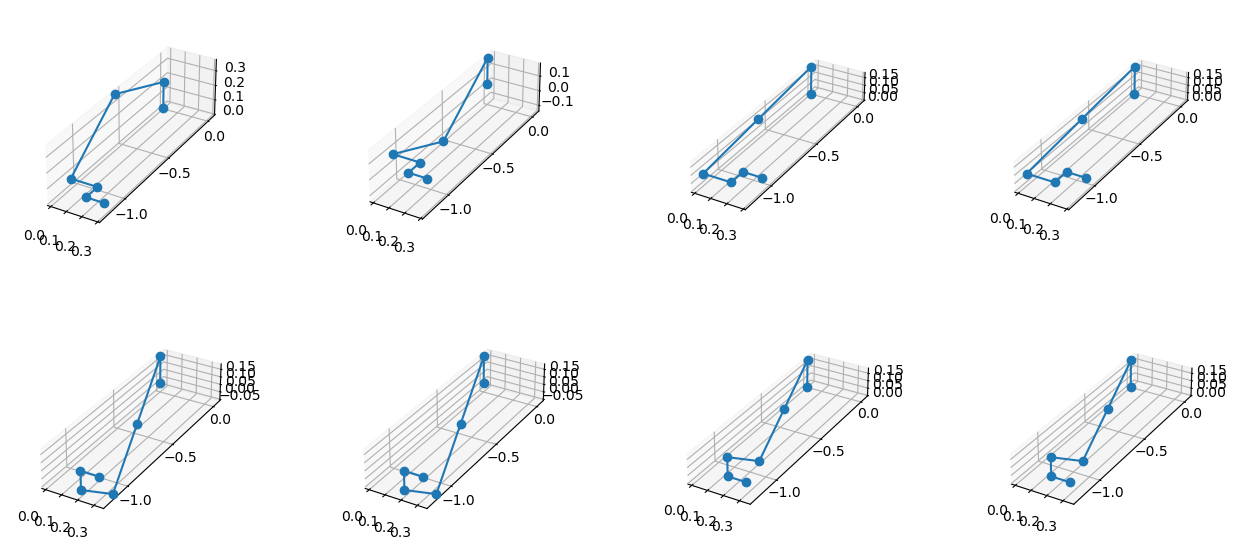

In [117]:
PlotSolutions(solutions)

## Singularities

Singularities happen when the determinant of the jacobian is 0. 

The jacobian of the ur10 can be found easily from the forward kinematics:
$$\boldsymbol{J}=\left[\begin{array}{l}
\boldsymbol{J}_{L_t} \\
\boldsymbol{J}_{A_t}
\end{array}\right]=\left[\begin{array}{c}
\boldsymbol{b}_{i} \times \boldsymbol{r}_{i, e} \\
\boldsymbol{b}_{i}
\end{array}\right]$$
where $\boldsymbol{b}_{i}$ is the z axis of frame i while $\boldsymbol{r}_{i, e}$ is the position of the end effector in frame i

The determinant is given by:
$$det(J)=s_3s_5a_2a_3(c_2a_2+c_{23}a_3+s_{234}d_5)$$

The determinant is zero when:
$$\theta_3 = 0, \pm \pi \\
\theta_5 = 0, \pm \pi \\
c_2a_2+c_{23}a_3+s_{234}d_5 = 0
$$
In general the robot is in a singular configuration when it is impossible to move the end-effector in atleast 1 direction.  
Source: https://www.mdpi.com/2218-6581/11/6/137